In [3]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors

In [4]:
motor_df = pd.read_csv("motor_window_features.csv")
secondary_df = pd.read_csv("secondary_window_features.csv")

print("Motor windows:", motor_df.shape)
print("Secondary windows:", secondary_df.shape)

secondary_df.head(5)

Motor windows: (174, 38)
Secondary windows: (106, 38)


,speed_kmh_mean,lat_mean,lon_mean,alt_mean,vert_acc_mean,horiz_acc_mean,course_mean,difcourse_mean,hdop_mean,vdop_mean,...,gps_speed_mean,max_speed_mean,speed_rel_mean,num_lanes_mean,lat_osm_mean,lon_osm_mean,osm_delay_mean,gps_speed_osm_mean,speed_ratio_mean,label
0,91.240625,40.526646,-3.423336,627.781250,5.421875,5.000000,306.257812,2.576344,0.296875,2.531250,...,91.104327,88.109375,0.96875,1.968750,40.526330,-3.422519,2.959000,90.890625,-0.546738,2
1,92.764062,40.538838,-3.454947,659.992188,5.656250,5.000000,298.306250,2.296172,0.203125,2.484375,...,92.667156,85.140625,1.12500,1.812500,40.538434,-3.453860,4.221875,92.462500,-0.412580,2
2,95.117188,40.551629,-3.491250,698.904688,5.968750,5.000000,294.450000,3.010266,0.265625,1.843750,...,95.123289,87.031250,1.31250,2.031250,40.551079,-3.490306,4.102469,95.145313,1.180434,2
3,99.273438,40.568392,-3.523362,667.884375,6.187500,5.000000,294.421875,2.834469,0.390625,2.109375,...,99.289772,90.468750,1.15625,2.171875,40.567937,-3.522519,3.000172,99.471875,1.097944,2
4,113.846875,40.528696,-3.428616,628.712500,5.187500,5.078125,298.756250,2.675219,0.593750,2.875000,...,113.908890,92.343750,1.09375,1.953125,40.528568,-3.428031,1.988625,113.910938,1.237124,0


We isolate normal driving windows to use them as the reference baseline for distance calculations.

In [5]:
motor_normal_df = motor_df[motor_df["label"] == 2]
secondary_normal_df = secondary_df[secondary_df["label"] == 2]

print("Motor NORMAL:", motor_normal_df.shape)
print("Secondary NORMAL:", secondary_normal_df.shape)

Motor NORMAL: (58, 38)
Secondary NORMAL: (39, 38)


We define which numeric driving features are used to measure similarity and distance.

In [6]:
feature_cols = (motor_normal_df.select_dtypes(include=["int64", "float64"]).drop(columns=["label"]).columns.tolist())
print("Number of features:", len(feature_cols))
feature_cols[:5]

Number of features: 37


['speed_kmh_mean', 'lat_mean', 'lon_mean', 'alt_mean', 'vert_acc_mean']

Scaling = teaching the system what “normal” looks like, feature by feature.

In [7]:
motor_scaler = StandardScaler()
secondary_scaler = StandardScaler()

motor_normal_scaled = motor_scaler.fit_transform(motor_normal_df[feature_cols])
secondary_normal_scaled = secondary_scaler.fit_transform(secondary_normal_df[feature_cols])

print("Scalers fitted for both road types")

Scalers fitted for both road types


In [8]:
motor_knn = NearestNeighbors(n_neighbors=5, metric="euclidean")
secondary_knn = NearestNeighbors(n_neighbors=5, metric="euclidean")

motor_knn.fit(motor_normal_scaled)
secondary_knn.fit(secondary_normal_scaled)

print("KNN models trained for motor & secondary")

KNN models trained for motor & secondary


In [9]:
def knn_distance(row, scaler, knn, feature_cols):
    row_df = row[feature_cols].to_frame().T
    row_scaled = scaler.transform(row_df)
    distances, _ = knn.kneighbors(row_scaled)
    return distances.mean()

Apply distance to all windows (per road)

In [10]:
motor_df["knn_distance"] = motor_df.apply(
    lambda row: knn_distance(row, motor_scaler, motor_knn, feature_cols),
    axis=1
)

In [11]:
secondary_df["knn_distance"] = secondary_df.apply(
    lambda row: knn_distance(row, secondary_scaler, secondary_knn, feature_cols),
    axis=1
)

In [12]:
print("Motor mean distance by label")
print(motor_df.groupby("label")["knn_distance"].mean())

print("\nSecondary mean distance by label")
print(secondary_df.groupby("label")["knn_distance"].mean())

Motor mean distance by label
label
0    19.754331
1    63.254465
2     3.577592
Name: knn_distance, dtype: float64

Secondary mean distance by label
label
0     8.163683
1    15.051760
2     4.180375
Name: knn_distance, dtype: float64


In [13]:
# Motor threshold (based on NORMAL only)
motor_normal_dist = motor_df[motor_df["label"] == 2]["knn_distance"]
motor_threshold = motor_normal_dist.mean() + 2 * motor_normal_dist.std()

# Secondary threshold
secondary_normal_dist = secondary_df[secondary_df["label"] == 2]["knn_distance"]
secondary_threshold = secondary_normal_dist.mean() + 2 * secondary_normal_dist.std()

motor_threshold, secondary_threshold

(np.float64(6.2254730357718975), np.float64(5.6229375986193215))

In [14]:
motor_abnormal = motor_df[motor_df["knn_distance"] > motor_threshold].copy()
secondary_abnormal = secondary_df[secondary_df["knn_distance"] > secondary_threshold].copy()

motor_abnormal.shape, secondary_abnormal.shape

((82, 39), (67, 39))

These are just quick checks to see if everything is okay

In [15]:
motor_abnormal["label"].value_counts()

,count
label,
1,58
0,21
2,3


In [16]:
motor_df.groupby("label")["knn_distance"].describe()

,count,mean,std,min,25%,50%,75%,max
label,,,,,,,,
0,52.0,19.754331,40.718379,3.311306,4.267894,5.654961,7.802823,202.324247
1,64.0,63.254465,58.126759,4.885960,8.830011,50.990718,100.326638,244.651420
2,58.0,3.577592,1.323941,2.259098,2.797049,3.113860,3.954000,9.081914


In [17]:
motor_df.shape, motor_abnormal.shape
len(motor_abnormal) / len(motor_df)

0.47126436781609193

Preparing data for clustering

In [18]:
motor_X = motor_scaler.transform(motor_abnormal[feature_cols])
secondary_X = secondary_scaler.transform(secondary_abnormal[feature_cols])

In [19]:
from sklearn.cluster import KMeans

motor_kmeans = KMeans(
    n_clusters=3,
    random_state=42,
    n_init=10
)

motor_clusters = motor_kmeans.fit_predict(motor_X)

motor_abnormal["cluster"] = motor_clusters
motor_abnormal["cluster"].value_counts()

,count
cluster,
0,54
1,19
2,9


In [20]:
secondary_kmeans = KMeans(
    n_clusters=3,
    random_state=42,
    n_init=10
)

secondary_clusters = secondary_kmeans.fit_predict(secondary_X)

secondary_abnormal["cluster"] = secondary_clusters
secondary_abnormal["cluster"].value_counts()

,count
cluster,
1,39
2,17
0,11


Naming the clusters, we decide this through seeing which features are the highest in each cluster (for each type of aggressive or drowsy behaving there is features that explain the type of this action, example: max_speed --> overspeeding and so on...

In [21]:
# Look at average feature values per cluster (motor)
motor_cluster_summary = (
    motor_abnormal
    .groupby("cluster")[feature_cols]
    .mean()
)

motor_cluster_summary

,speed_kmh_mean,lat_mean,lon_mean,alt_mean,vert_acc_mean,horiz_acc_mean,course_mean,difcourse_mean,hdop_mean,vdop_mean,...,num_vehicles_mean,gps_speed_mean,max_speed_mean,speed_rel_mean,num_lanes_mean,lat_osm_mean,lon_osm_mean,osm_delay_mean,gps_speed_osm_mean,speed_ratio_mean
cluster,,,,,,,,,,,,,,,,,,,,,
0,92.698785,40.474965,-3.437817,591.587008,3.622106,5.001447,184.784172,2.293389,0.425347,2.456597,...,1.454548,92.688568,104.553241,0.979456,2.424479,39.338164,-3.343247,1.374106,92.693229,-3.736482
1,96.786760,40.480537,-3.412900,591.917352,4.010691,5.008224,138.631743,1.077618,0.760691,4.690789,...,1.647077,96.752966,117.258224,1.013158,2.930099,40.480528,-3.413003,2.062301,96.763487,0.537677
2,103.791146,40.480308,-3.413121,591.742014,4.281250,5.052083,245.287326,1.308042,0.328125,1.774306,...,1.649730,103.792952,113.194444,1.065972,2.836806,40.480474,-3.412714,1.742707,103.806771,-2.110217


In [22]:
# Look at average feature values per cluster (secondary)
secondary_cluster_summary = (
    secondary_abnormal
    .groupby("cluster")[feature_cols]
    .mean()
)

secondary_cluster_summary

,speed_kmh_mean,lat_mean,lon_mean,alt_mean,vert_acc_mean,horiz_acc_mean,course_mean,difcourse_mean,hdop_mean,vdop_mean,...,num_vehicles_mean,gps_speed_mean,max_speed_mean,speed_rel_mean,num_lanes_mean,lat_osm_mean,lon_osm_mean,osm_delay_mean,gps_speed_osm_mean,speed_ratio_mean
cluster,,,,,,,,,,,,,,,,,,,,,
0,105.423864,40.541942,-3.466214,651.248295,4.224432,5.042614,305.367756,2.613810,0.301136,1.735795,...,0.584197,105.445847,88.573864,1.144886,1.936080,40.541690,-3.465677,1.905416,105.460938,0.570380
1,89.856891,40.549476,-3.482158,666.862620,3.643429,5.000000,118.288061,2.165746,0.772436,4.719551,...,0.273021,89.849015,89.457532,1.128606,2.046474,40.549666,-3.482578,1.697770,89.832572,0.891769
2,87.460938,40.555042,-3.493988,674.646324,3.719669,5.000000,303.846599,1.842494,0.278493,2.008272,...,0.918786,87.495392,87.578125,1.084559,1.994485,40.554791,-3.493446,2.217870,87.504779,0.617021


In [23]:
motor_cluster_summary["harsh_score"] = (
    motor_cluster_summary["vert_acc_mean"].rank() +
    motor_cluster_summary["horiz_acc_mean"].rank()
)

motor_cluster_summary["overspeed_score"] = (
    motor_cluster_summary["speed_kmh_mean"].rank() +
    motor_cluster_summary["speed_ratio_mean"].rank()
)

motor_cluster_summary["unstable_score"] = (
    motor_cluster_summary["difcourse_mean"].rank()
)

motor_cluster_summary[
    ["harsh_score", "overspeed_score", "unstable_score"]
]

,harsh_score,overspeed_score,unstable_score
cluster,,,
0,2.0,2.0,3.0
1,4.0,5.0,1.0
2,6.0,5.0,2.0


In [24]:
motor_cluster_labels = {}

for cluster_id, row in motor_cluster_summary.iterrows():

    scores = {
        "Overspeeding": row["overspeed_score"],
        "Harsh acceleration / braking": row["harsh_score"],
        "Unstable driving": row["unstable_score"]
    }

    dominant_behavior = max(scores, key=scores.get)
    motor_cluster_labels[cluster_id] = dominant_behavior

motor_cluster_labels

{0: 'Unstable driving', 1: 'Overspeeding', 2: 'Harsh acceleration / braking'}

In [25]:
motor_cluster_summary[
    ["speed_kmh_mean", "vert_acc_mean", "horiz_acc_mean", "difcourse_mean",
     "overspeed_score", "harsh_score", "unstable_score"]
]

,speed_kmh_mean,vert_acc_mean,horiz_acc_mean,difcourse_mean,overspeed_score,harsh_score,unstable_score
cluster,,,,,,,
0,92.698785,3.622106,5.001447,2.293389,2.0,2.0,3.0
1,96.786760,4.010691,5.008224,1.077618,5.0,4.0,1.0
2,103.791146,4.281250,5.052083,1.308042,5.0,6.0,2.0


Now for secondary

In [26]:
secondary_cluster_summary["overspeed_score"] = (
    secondary_cluster_summary["speed_kmh_mean"].rank() +
    secondary_cluster_summary["speed_ratio_mean"].rank()
)

secondary_cluster_summary["harsh_score"] = (
    secondary_cluster_summary["vert_acc_mean"].rank() +
    secondary_cluster_summary["horiz_acc_mean"].rank()
)

secondary_cluster_summary["unstable_score"] = (
    secondary_cluster_summary["difcourse_mean"].rank()
)

In [27]:
secondary_cluster_labels = {}

for cluster_id, row in motor_cluster_summary.iterrows():

    scores = {
        "Overspeeding": row["overspeed_score"],
        "Harsh acceleration / braking": row["harsh_score"],
        "Unstable driving": row["unstable_score"]
    }

    dominant_behavior = max(scores, key=scores.get)
    secondary_cluster_labels[cluster_id] = dominant_behavior

secondary_cluster_labels

{0: 'Unstable driving', 1: 'Overspeeding', 2: 'Harsh acceleration / braking'}

In [28]:
secondary_cluster_summary[
    ["speed_kmh_mean", "vert_acc_mean", "horiz_acc_mean", "difcourse_mean",
     "overspeed_score", "harsh_score", "unstable_score"]
]

,speed_kmh_mean,vert_acc_mean,horiz_acc_mean,difcourse_mean,overspeed_score,harsh_score,unstable_score
cluster,,,,,,,
0,105.423864,4.224432,5.042614,2.613810,4.0,6.0,3.0
1,89.856891,3.643429,5.000000,2.165746,5.0,2.5,2.0
2,87.460938,3.719669,5.000000,1.842494,3.0,3.5,1.0


### KNN NORMAL DIFFERENCES (Tells us how far a window is from normal driving) & CLUSTERING (Tell us what type of abnormal behaviour it looks like) PHASE IS DONE

### Now we move to the next step: ALERTS APPEARING ON THE APP:
This is the logic:

If knn_distance > threshold → abnormal
Else → no alert


In [29]:
def motor_alert(row, threshold):
    if row["knn_distance"] <= threshold:
        return "No alert"

    return row["cluster_label"]

Here we only assign clusters and behavior labels to windows that are far from normal, while normal windows remain unclustered and produce no alerts.

In [30]:
motor_df["cluster"] = np.nan
motor_df.loc[motor_abnormal.index, "cluster"] = motor_abnormal["cluster"]
motor_df["cluster_label"] = motor_df["cluster"].map(motor_cluster_labels)

In [31]:
secondary_df["cluster"] = np.nan
secondary_df.loc[secondary_abnormal.index, "cluster"] = secondary_abnormal["cluster"]
secondary_df["cluster_label"] = secondary_df["cluster"].map(secondary_cluster_labels)

In [32]:
motor_df["alert"] = motor_df.apply(
    lambda row: motor_alert(row, motor_threshold),
    axis=1
)

motor_df[["knn_distance", "cluster_label", "alert"]].head(10)

,knn_distance,cluster_label,alert
0,6.962918,Unstable driving,Unstable driving
1,3.204688,NaN,No alert
2,2.700637,NaN,No alert
3,3.151015,NaN,No alert
4,2.976016,NaN,No alert
5,6.030598,NaN,No alert
6,5.889323,NaN,No alert
7,3.828616,NaN,No alert
8,3.093380,NaN,No alert
9,2.916400,NaN,No alert


In [33]:
secondary_df["alert"] = secondary_df.apply(
    lambda row: motor_alert(row, secondary_threshold),
    axis=1
)

secondary_df[["knn_distance", "cluster_label", "alert"]].head(10)

,knn_distance,cluster_label,alert
0,5.089209,NaN,No alert
1,4.992051,NaN,No alert
2,5.067595,NaN,No alert
3,5.175336,NaN,No alert
4,9.727734,Unstable driving,Unstable driving
5,9.138435,Unstable driving,Unstable driving
6,13.264669,Unstable driving,Unstable driving
7,10.773913,Unstable driving,Unstable driving
8,15.316556,Overspeeding,Overspeeding
9,15.362665,Overspeeding,Overspeeding


In [34]:
motor_df["alert"].value_counts()

,count
alert,
No alert,92
Unstable driving,54
Overspeeding,19
Harsh acceleration / braking,9


In [35]:
secondary_df["alert"].value_counts()

,count
alert,
No alert,39
Overspeeding,39
Harsh acceleration / braking,17
Unstable driving,11


Now we create the mapping messages

In [36]:
alert_messages = {
    "Overspeeding": "⚠️ Speed limit exceeded",
    "Harsh acceleration / braking": "⚠️ Harsh driving detected",
    "Unstable driving": "⚠️ Vehicle instability detected",
    "No alert": "Normal driving"
}

In [37]:
motor_df["alert_message"] = motor_df["alert"].map(alert_messages)
secondary_df["alert_message"] = secondary_df["alert"].map(alert_messages)

In [38]:
motor_df[["alert", "alert_message"]].head()

,alert,alert_message
0,Unstable driving,⚠️ Vehicle instability detected
1,No alert,Normal driving
2,No alert,Normal driving
3,No alert,Normal driving
4,No alert,Normal driving


In [39]:
secondary_df[["alert", "alert_message"]].head()

,alert,alert_message
0,No alert,Normal driving
1,No alert,Normal driving
2,No alert,Normal driving
3,No alert,Normal driving
4,Unstable driving,⚠️ Vehicle instability detected


### Normalizing

In [40]:
motor_alert_pct = (
    motor_df["alert"]
    .value_counts(normalize=True) * 100
).round(2)

motor_alert_pct

,proportion
alert,
No alert,52.87
Unstable driving,31.03
Overspeeding,10.92
Harsh acceleration / braking,5.17


In [41]:
secondary_alert_pct = (
    secondary_df["alert"]
    .value_counts(normalize=True) * 100
).round(2)

secondary_alert_pct

,proportion
alert,
No alert,36.79
Overspeeding,36.79
Harsh acceleration / braking,16.04
Unstable driving,10.38


### Side-by-side comparison table

In [42]:
alert_comparison = (
    pd.concat(
        [
            motor_alert_pct.rename("Motorway (%)"),
            secondary_alert_pct.rename("Secondary (%)")
        ],
        axis=1
    )
    .fillna(0)
)

alert_comparison

,Motorway (%),Secondary (%)
alert,,
No alert,52.87,36.79
Unstable driving,31.03,10.38
Overspeeding,10.92,36.79
Harsh acceleration / braking,5.17,16.04


<Axes: title={'center': 'Alert Distribution by Road Type'}, xlabel='alert'>

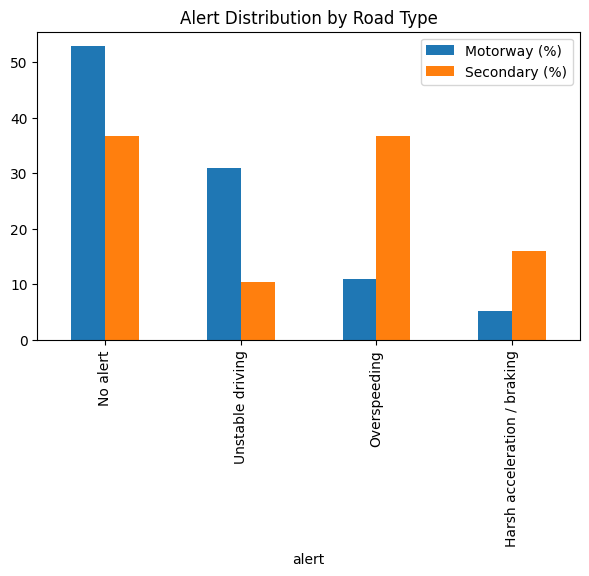

In [43]:
alert_comparison.plot(
    kind="bar",
    figsize=(7,4),
    title="Alert Distribution by Road Type"
)

The alert distribution aligns with real-world driving expectations, confirming that the KNN-based detection and clustering pipeline produces meaningful and context-aware driving risk alerts.

# NOW WE REACHED THE PERFORMANCE SCORING

### `“Given all detected behaviours, how risky is this driving profile?”`



We need a score that: increases when alerts increase, increases when alerts are severe and easy to explain

The clean formula we’ll use
Average severity × scaling factor

In [44]:
severity_map = {
    "No alert": 0,
    "Unstable driving": 1,
    "Harsh acceleration / braking": 2,
    "Overspeeding": 3
}

In [45]:
motor_df["severity"] = motor_df["alert"].map(severity_map)
secondary_df["severity"] = secondary_df["alert"].map(severity_map)

In [46]:
motor_avg_severity = motor_df["severity"].mean()
motor_avg_severity

np.float64(0.7413793103448276)

In [47]:
secondary_avg_severity = secondary_df["severity"].mean()
secondary_avg_severity

np.float64(1.528301886792453)

Here we define the formula

In [48]:
def compute_session_performance(df, max_severity=3):
    avg_severity = df["severity"].mean()
    score = 100 - (avg_severity / max_severity) * 100
    return round(score, 2)

In [50]:
motor_score = compute_session_performance(motor_df)
secondary_score = compute_session_performance(secondary_df)

motor_score, secondary_score

(np.float64(75.29), np.float64(49.06))

# phase 3

Compute normal_score and severity input s (0–1) from k-NN distance

In [51]:
import numpy as np
import pandas as pd

NORMAL_LABEL = 2

# Convert distance -> normal_score (bounded)
motor_df["normal_score"] = 1.0 / (1.0 + motor_df["knn_distance"])
secondary_df["normal_score"] = 1.0 / (1.0 + secondary_df["knn_distance"])

# Road-specific quantiles from NORMAL windows (used to normalize severity for fuzzy)
motor_q95 = motor_df.loc[motor_df["label"]==NORMAL_LABEL, "knn_distance"].quantile(0.95)
motor_q99 = motor_df.loc[motor_df["label"]==NORMAL_LABEL, "knn_distance"].quantile(0.99)

sec_q95   = secondary_df.loc[secondary_df["label"]==NORMAL_LABEL, "knn_distance"].quantile(0.95)
sec_q99   = secondary_df.loc[secondary_df["label"]==NORMAL_LABEL, "knn_distance"].quantile(0.99)

def normalize_distance(d, q95, q99):
    # maps knn_distance -> severity s in [0,1]
    if d <= q95: return 0.0
    if d >= q99: return 1.0
    return float((d - q95) / (q99 - q95))


We explain abnormality in the same space as k-NN: standardized features.

In [52]:
def window_zscores(df, scaler, cols):
    Z = scaler.transform(df[cols])
    return pd.DataFrame(Z, columns=cols, index=df.index)

motor_Z = window_zscores(motor_df, motor_scaler, feature_cols)
sec_Z   = window_zscores(secondary_df, secondary_scaler, feature_cols)

# squared deviation per feature (in z-space)
motor_contrib = motor_Z**2
sec_contrib   = sec_Z**2

# normalize per window -> percentages (sum = 1)
motor_contrib_norm = motor_contrib.div(motor_contrib.sum(axis=1).replace(0,np.nan), axis=0).fillna(0)
sec_contrib_norm   = sec_contrib.div(sec_contrib.sum(axis=1).replace(0,np.nan), axis=0).fillna(0)


In [53]:
def pick_cols_by_keywords(cols, keywords):
    cols = list(cols)
    out = []
    for c in cols:
        lc = c.lower()
        if any(k in lc for k in keywords):
            out.append(c)
    return out

CAUSE_GROUPS = {
    "Overspeed": pick_cols_by_keywords(feature_cols, ["speed", "max_speed", "speed_ratio", "gps_speed"]),
    "Tailgating": pick_cols_by_keywords(feature_cols, ["dist_front", "ttc_front", "headway", "num_vehicles"]),
    "Harsh maneuvers": pick_cols_by_keywords(feature_cols, ["acc_", "vert_acc", "horiz_acc", "jerk"]),
    "Unstable steering": pick_cols_by_keywords(feature_cols, ["difcourse", "yaw", "steer"]),
}

# remove empty groups (if any keywords don't exist in your file)
CAUSE_GROUPS = {k:v for k,v in CAUSE_GROUPS.items() if len(v)>0}
print("CAUSE_GROUPS:", {k: len(v) for k,v in CAUSE_GROUPS.items()})


CAUSE_GROUPS: {'Overspeed': 6, 'Tailgating': 3, 'Harsh maneuvers': 8, 'Unstable steering': 2}


In [54]:
def cause_percentages(contrib_norm_row, cause_groups):
    out = {}
    for cause, cols in cause_groups.items():
        cols = [c for c in cols if c in contrib_norm_row.index]
        if cols:
            out[cause] = float(contrib_norm_row[cols].sum())
    s = sum(out.values())
    if s > 0:
        out = {k: v/s for k,v in out.items()}  # re-normalize causes to sum=1
    return dict(sorted(out.items(), key=lambda x: x[1], reverse=True))

motor_df["top_causes_norm"] = motor_contrib_norm.apply(lambda r: cause_percentages(r, CAUSE_GROUPS), axis=1)
secondary_df["top_causes_norm"] = sec_contrib_norm.apply(lambda r: cause_percentages(r, CAUSE_GROUPS), axis=1)


tsk fuzzy

In [55]:
def tri(x, a, b, c):
    if x < a or x > c: return 0.0
    if x == b: return 1.0
    if a <= x < b:
        return 0.0 if b == a else (x - a) / (b - a)
    return 0.0 if c == b else (c - x) / (c - b)

def trap(x, a, b, c, d):
    if x < a or x > d: return 0.0
    if b <= x <= c: return 1.0
    if a <= x < b:
        return 0.0 if b == a else (x - a) / (b - a)
    return 0.0 if d == c else (d - x) / (d - c)

def fuzzify_inputs(s, p):
    # severity sets
    s_low  = trap(s, 0.0, 0.0, 0.2, 0.4)
    s_med  = tri (s, 0.3, 0.6, 0.85)
    s_high = trap(s, 0.7, 0.85, 1.0, 1.0)

    # dominance sets (tuned for percentages)
    p_small = trap(p, 0.0, 0.0, 0.15, 0.30)
    p_med   = tri (p, 0.25, 0.45, 0.65)
    p_dom   = trap(p, 0.45, 0.60, 1.0, 1.0)

    return {"s_low": s_low, "s_med": s_med, "s_high": s_high,
            "p_small": p_small, "p_med": p_med, "p_dom": p_dom}

def tsk_output(weights, outputs):
    w = np.array(weights, dtype=float)
    y = np.array(outputs, dtype=float)
    if w.sum() == 0:
        return 0.0
    return float((w*y).sum() / w.sum())

def intensity_for_cause(s, p):
    m = fuzzify_inputs(s, p)
    w1 = m["s_high"] * m["p_dom"]
    w2 = m["s_med"]  * m["p_dom"]
    w3 = m["s_high"] * m["p_med"]
    w4 = m["p_small"]
    return tsk_output([w1,w2,w3,w4], [0.95, 0.80, 0.60, 0.10])


In [56]:
MSG = {
    "Overspeed": "Reduce speed and keep within the road limit.",
    "Tailgating": "Increase following distance and keep a safe time gap.",
    "Harsh maneuvers": "Avoid harsh braking/acceleration; drive more smoothly.",
    "Unstable steering": "Avoid sudden steering/lane changes; keep smoother control."
}

def phase3_for_row(knn_d, q95, q99, causes_norm_dict):
    s = normalize_distance(knn_d, q95, q99)
    ranked = []
    for cause, p in causes_norm_dict.items():
        inten = intensity_for_cause(s, p)
        ranked.append((cause, p, inten, MSG.get(cause, cause)))
    ranked.sort(key=lambda x: x[2], reverse=True)  # sort by intensity
    return s, ranked

def build_phase3_table(df, q95, q99, top_col="top_causes_norm"):
    rows = []
    for idx, r in df.iterrows():
        s, ranked = phase3_for_row(float(r["knn_distance"]), q95, q99, r[top_col])
        rows.append({
            "index": idx,
            "label": int(r["label"]),
            "knn_distance": float(r["knn_distance"]),
            "severity_0_1": float(s),
            "top_2": ranked[:2],   # (cause, percent, intensity, msg)
        })
    return pd.DataFrame(rows)

motor_phase3 = build_phase3_table(motor_df, motor_q95, motor_q99)
sec_phase3   = build_phase3_table(secondary_df, sec_q95, sec_q99)

motor_phase3.head(10)


,index,label,knn_distance,severity_0_1,top_2
0,0,2,6.962918,0.471458,"[(Harsh maneuvers, 0.729855951401501, 0.8, Avo..."
1,1,2,3.204688,0.000000,"[(Tailgating, 0.1350859738156038, 0.1, Increas..."
2,2,2,2.700637,0.000000,"[(Tailgating, 0.06602227708444351, 0.1, Increa..."
3,3,2,3.151015,0.000000,"[(Overspeed, 0.241963655766128, 0.100000000000..."
4,4,2,2.976016,0.000000,"[(Tailgating, 0.234563988642232, 0.10000000000..."
5,5,2,6.030598,0.000000,"[(Unstable steering, 0.0854338111115253, 0.1, ..."
6,6,2,5.889323,0.000000,"[(Unstable steering, 0.11751118406618745, 0.1,..."
7,7,2,3.828616,0.000000,"[(Harsh maneuvers, 0.20949305048871822, 0.1, A..."
8,8,2,3.093380,0.000000,"[(Unstable steering, 0.23409085826627604, 0.10..."
9,9,2,2.916400,0.000000,"[(Tailgating, 0.20908195222941928, 0.1, Increa..."


In [57]:
motor_abn = motor_phase3[motor_phase3["label"] != NORMAL_LABEL].sort_values("knn_distance", ascending=False).head(10)
sec_abn   = sec_phase3[sec_phase3["label"] != NORMAL_LABEL].sort_values("knn_distance", ascending=False).head(10)

display(motor_abn)
display(sec_abn)


,index,label,knn_distance,severity_0_1,top_2
173,173,1,244.651420,1.0,"[(Tailgating, 0.5003743556778343, 0.7084361603..."
170,170,1,221.675408,1.0,"[(Harsh maneuvers, 0.4589483009155416, 0.62057..."
40,40,0,202.324247,1.0,"[(Tailgating, 0.5073446447931094, 0.7221315231..."
60,60,1,186.926797,1.0,"[(Harsh maneuvers, 0.5967286570658384, 0.87509..."
41,41,0,179.209855,1.0,"[(Harsh maneuvers, 0.6270993443177122, 0.91404..."
172,172,1,171.814225,1.0,"[(Tailgating, 0.5882907831328148, 0.8622369137..."
171,171,1,171.737202,1.0,"[(Harsh maneuvers, 0.3981000855036028, 0.6, Av..."
26,26,1,144.838464,1.0,"[(Harsh maneuvers, 0.5811478612732718, 0.85112..."
163,163,1,132.145715,1.0,"[(Harsh maneuvers, 0.9996429556988111, 0.95, A..."
59,59,1,129.431594,1.0,"[(Harsh maneuvers, 0.32012630151599536, 0.6, A..."


,index,label,knn_distance,severity_0_1,top_2
59,59,1,17.843988,1.0,"[(Overspeed, 0.39868023390952223, 0.6, Reduce ..."
64,64,1,17.319013,1.0,"[(Unstable steering, 0.5079492037076178, 0.723..."
104,104,1,17.275297,1.0,"[(Unstable steering, 0.5477184686322166, 0.796..."
65,65,1,17.077730,1.0,"[(Harsh maneuvers, 0.4696441763526577, 0.64438..."
103,103,1,16.914402,1.0,"[(Harsh maneuvers, 0.5793868715644183, 0.84834..."
105,105,1,16.397091,1.0,"[(Unstable steering, 0.5147657583276533, 0.736..."
95,95,0,16.387700,1.0,"[(Harsh maneuvers, 0.8397617554810711, 0.95, A..."
58,58,1,16.078563,1.0,"[(Unstable steering, 0.5328709391479816, 0.769..."
60,60,1,15.987257,1.0,"[(Overspeed, 0.5398602080568575, 0.78236200582..."
29,29,1,15.719194,1.0,"[(Unstable steering, 0.4545482013009305, 0.610..."


In [58]:
def pct_dict(d, top_n=None):
    # d can be dict or list of tuples
    if isinstance(d, list):
        d = dict(d)
    items = list(d.items())
    if top_n is not None:
        items = items[:top_n]
    return {k: f"{v*100:.1f}%" for k, v in items}

def dict_topn(d, n=5):
    return dict(list(d.items())[:n])  # keeps ordering if already sorted


In [61]:
for idx, r in motor_phase3.iterrows():
    # Get top causes from motor_df using the index from motor_phase3
    top_causes_list = [(cause_tuple[0], cause_tuple[1]) for cause_tuple in r["top_2"]]
    # Get top features from motor_contrib_norm using the index from motor_phase3
    top_features_dict = motor_contrib_norm.loc[r["index"]].nlargest(6).to_dict()

    print("window:", r["index"], "knn:", round(float(r["knn_distance"]), 3))
    print("Top causes:", pct_dict(top_causes_list))
    print("Top features:", pct_dict(top_features_dict))
    print("----")

window: 0 knn: 6.963
Top causes: {'Harsh maneuvers': '73.0%', 'Tailgating': '4.9%'}
Top features: {'pdop_mean': '73.6%', 'vert_acc_mean': '3.5%', 'lat_mean': '3.4%', 'vdop_mean': '3.2%', 'lon_mean': '2.2%', 'pitch_mean': '2.0%'}
----
window: 1 knn: 3.205
Top causes: {'Tailgating': '13.5%', 'Unstable steering': '2.0%'}
Top features: {'vert_acc_mean': '22.0%', 'dist_front_mean': '8.0%', 'speed_kmh_mean': '7.9%', 'gps_speed_osm_mean': '7.9%', 'gps_speed_mean': '7.9%', 'pitch_mean': '7.0%'}
----
window: 2 knn: 2.701
Top causes: {'Tailgating': '6.6%', 'Unstable steering': '1.6%'}
Top features: {'vert_acc_mean': '28.7%', 'alt_mean': '15.7%', 'gps_speed_mean': '8.3%', 'gps_speed_osm_mean': '8.3%', 'roll_mean': '8.2%', 'speed_kmh_mean': '8.2%'}
----
window: 3 knn: 3.151
Top causes: {'Overspeed': '24.2%', 'Tailgating': '5.2%'}
Top features: {'vert_acc_mean': '38.2%', 'alt_mean': '19.1%', 'gps_speed_mean': '4.6%', 'gps_speed_osm_mean': '4.6%', 'speed_kmh_mean': '4.5%', 'roll_mean': '4.3%'}
----


In [64]:
print(motor_phase3.columns.tolist())

['index', 'label', 'knn_distance', 'severity_0_1', 'top_2']


In [66]:
print("\n=== MOTOR ===")
for idx, r in motor_phase3.iterrows():
    top_causes_list = [(cause_tuple[0], cause_tuple[1]) for cause_tuple in r["top_2"]]
    top_features_dict = motor_contrib_norm.loc[r["index"]].nlargest(6).to_dict()

    print("window:", r["index"], "knn:", round(float(r["knn_distance"]), 3))
    print("Top causes:", pct_dict(top_causes_list))
    print("Top features:", pct_dict(top_features_dict))
    print("----")

print("\n=== SECONDARY ===")
for idx, r in sec_phase3.iterrows():
    top_causes_list = [(cause_tuple[0], cause_tuple[1]) for cause_tuple in r["top_2"]]
    top_features_dict = sec_contrib_norm.loc[r["index"]].nlargest(6).to_dict()

    print("window:", r["index"], "knn:", round(float(r["knn_distance"]), 3))
    print("Top causes:", pct_dict(top_causes_list))
    print("Top features:", pct_dict(top_features_dict))
    print("----")


=== MOTOR ===
window: 0 knn: 6.963
Top causes: {'Harsh maneuvers': '73.0%', 'Tailgating': '4.9%'}
Top features: {'pdop_mean': '73.6%', 'vert_acc_mean': '3.5%', 'lat_mean': '3.4%', 'vdop_mean': '3.2%', 'lon_mean': '2.2%', 'pitch_mean': '2.0%'}
----
window: 1 knn: 3.205
Top causes: {'Tailgating': '13.5%', 'Unstable steering': '2.0%'}
Top features: {'vert_acc_mean': '22.0%', 'dist_front_mean': '8.0%', 'speed_kmh_mean': '7.9%', 'gps_speed_osm_mean': '7.9%', 'gps_speed_mean': '7.9%', 'pitch_mean': '7.0%'}
----
window: 2 knn: 2.701
Top causes: {'Tailgating': '6.6%', 'Unstable steering': '1.6%'}
Top features: {'vert_acc_mean': '28.7%', 'alt_mean': '15.7%', 'gps_speed_mean': '8.3%', 'gps_speed_osm_mean': '8.3%', 'roll_mean': '8.2%', 'speed_kmh_mean': '8.2%'}
----
window: 3 knn: 3.151
Top causes: {'Overspeed': '24.2%', 'Tailgating': '5.2%'}
Top features: {'vert_acc_mean': '38.2%', 'alt_mean': '19.1%', 'gps_speed_mean': '4.6%', 'gps_speed_osm_mean': '4.6%', 'speed_kmh_mean': '4.5%', 'roll_mean'